In [1]:
#importing necessary packages
# ---------------------------------------------------------
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn as sns


from sklearn.ensemble import VotingClassifier
sys.path.append('../../../../pywholebrain')
from hdf5manager import hdf5manager as h5
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('publication')

save = True

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#creating appropriate datasets
# ---------------------------------------------------------

wd = '/home/brian/Documents/data/Classifier/'

classifier_h5 = h5(wd + 'p21_classifier.hdf5')
var = classifier_h5.load('training_keys')
data = pd.read_csv(wd + 'p21_classifier_ns_metrics.tsv', sep = "\t", index_col='exp_ic').copy()

domain_vars = ['spatial.min', 'spatial.max', 'region.centroid.0',
               'threshold.area', 'region.minaxis', 'region.majaxis','region.eccentricity', 
               'freq.rangesz', 'freq.maxsnr', 'freq.range.low', 'freq.range.high',
               'temporal.max', 'temporal.std','temporal.autocorr']

nodomain_vars =['spatial.min', 'spatial.max',
                'freq.rangesz','freq.maxsnr', 'freq.range.low', 'freq.range.high',
                'temporal.max', 'temporal.std', 'temporal.autocorr']



current_anml = 'nope'
j=0
for i in data.index.to_list():
    if current_anml == i[:9]:
        data.loc[i, 'anml'] = j
    else:
        current_anml = i[:9]
        j+=1
        data.loc[i, 'anml'] = j
print(data.columns)
data = data[data['anml']!=2]# drop 171003_05 from the dataset - 
'''
171003_05 is a weird dataset. Very few ICs, many with no threshold
'''

dataAll = data[domain_vars].fillna(value=0).copy()

dataNoThresh = data[data['threshold.area'] == 0].copy()
dataNoThresh = dataNoThresh[nodomain_vars].fillna(value=0).copy()

dataThresh = data[data['threshold.area'] != 0].copy()
dataThresh = dataThresh[domain_vars].fillna(value=0).copy()

for col in dataAll.columns:
    dataAll[col] = (dataAll[col] - np.mean(dataAll[col])) / (np.std(dataAll[col], ddof=1)) 
for col in dataThresh.columns:
    dataThresh[col] = (dataThresh[col] - np.mean(dataThresh[col])) / (np.std(dataThresh[col], ddof=1)) 
for col in dataNoThresh.columns:
    dataNoThresh[col] = (dataNoThresh[col] - np.mean(dataNoThresh[col])) / (np.std(dataNoThresh[col], ddof=1)) 

Index(['age', 'artifact', 'freq.avgsnr', 'freq.integrate', 'freq.maxsnr',
       'freq.maxsnr.freq', 'freq.range.high', 'freq.range.low', 'freq.rangesz',
       'length', 'mass.perc', 'mass.region', 'mass.total', 'region.centroid.0',
       'region.centroid.1', 'region.eccentricity', 'region.extent',
       'region.majaxis', 'region.majmin.ratio', 'region.minaxis',
       'region.orient', 'signal', 'spatial.COMall.x', 'spatial.COMall.y',
       'spatial.COMdom.x', 'spatial.COMdom.y', 'spatial.avg', 'spatial.max',
       'spatial.min', 'spatial.n.domains', 'spatial.std', 'temporal.autocorr',
       'temporal.max', 'temporal.min', 'temporal.n.freq', 'temporal.std',
       'threshold.area', 'threshold.perc', 'anml'],
      dtype='object')


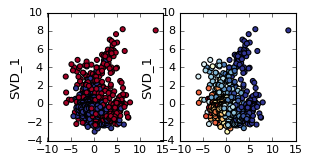

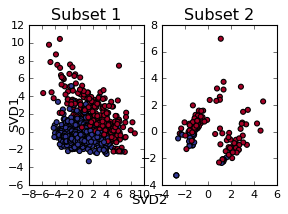

In [3]:
#Plotting TruncatedSVD Plot
# ---------------------------------------------------------
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)

X_reduced_SVD = svd.fit_transform(dataThresh.values)

X_reduced_SVD2 = svd.fit_transform(dataNoThresh.values)

X_reduced_SVD3 = svd.fit_transform(dataAll.values)


fig = plt.figure(figsize = (4,2), constrained_layout=False)

gs = fig.add_gridspec(1, 2)
gs.update(wspace = 0.15, hspace = 1)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

ax0.scatter(X_reduced_SVD3[:, 0], X_reduced_SVD3[:, 1], c=data.loc[dataAll.index, 'signal'], 
            cmap=plt.cm.get_cmap('RdYlBu',2), s = 20, alpha = 1)
ax0.set_ylabel('SVD_1')

# ax1.scatter(X_reduced_SVD3[:, 0], X_reduced_SVD3[:, 1], c=data.loc[dataAll.index, 'signal'], 
#             cmap=plt.cm.get_cmap('RdYlBu',2), s = 20, alpha = 1)
ph1 = ax1.scatter(X_reduced_SVD3[:, 0], 
                  X_reduced_SVD3[:, 1],
                  c=data.loc[dataAll.index, 'region.minaxis'], 
            cmap=plt.cm.get_cmap('RdYlBu_r'), s = 20, alpha = 1)
ax1.set_ylabel('SVD_1')

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.2)
# cbar2 = fig.colorbar(ph1, ticks=[], cax=cax, orientation='vertical')
# cbar2.ax.set_yticklabels(['Artifact', 'Signal'], rotation = 90)
# cbar2.ax.yaxis.set_ticks_position('left')
# cbar2.ax.tick_params(size=0)
# cbar2.ax.axis('off')


if save: 
    plt.savefig('SVD_plots_all.svg', dpi = 600)
plt.show()


fig = plt.figure(figsize = (4,2.5), constrained_layout=False)

gs = fig.add_gridspec(1, 2)
gs.update(wspace = 0.15, hspace = 0.5)


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

fig.text(0.08, 0.5, 'SVD1', ha='center',rotation='vertical')
fig.text(0.5, 0.01, 'SVD2', ha='center')

ph1 = ax1.scatter(X_reduced_SVD[:, 0], X_reduced_SVD[:, 1], c=data.loc[dataThresh.index, 'signal'], 
            cmap=plt.cm.get_cmap('RdYlBu',2), s = 20, alpha = 1)
ax1.set_title('Subset 1')

ax2.set_title('Subset 2')
ph2 = ax2.scatter(X_reduced_SVD2[:, 0], X_reduced_SVD2[:, 1], c=data.loc[dataNoThresh.index, 'signal'], 
            cmap=plt.cm.get_cmap('RdYlBu',2), s = 20, alpha = 1)

if save: 
    plt.savefig('SVD_plots_subsets.svg', dpi = 600)
plt.show()


# ---------------------------------------------------------

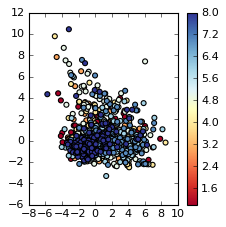

In [13]:
plt.scatter(X_reduced_SVD[:, 0], X_reduced_SVD[:, 1], c=data.loc[dataThresh.index, 'anml'], 
            cmap=plt.cm.get_cmap('RdYlBu'), s = 20, alpha = 1)
plt.colorbar()
plt.show()

Index(['age', 'artifact', 'freq.avgsnr', 'freq.integrate', 'freq.maxsnr',
       'freq.maxsnr.freq', 'freq.range.high', 'freq.range.low', 'freq.rangesz',
       'length', 'mass.perc', 'mass.region', 'mass.total', 'region.centroid.0',
       'region.centroid.1', 'region.eccentricity', 'region.extent',
       'region.majaxis', 'region.majmin.ratio', 'region.minaxis',
       'region.orient', 'signal', 'spatial.COMall.x', 'spatial.COMall.y',
       'spatial.COMdom.x', 'spatial.COMdom.y', 'spatial.avg', 'spatial.max',
       'spatial.min', 'spatial.n.domains', 'spatial.std', 'temporal.autocorr',
       'temporal.max', 'temporal.min', 'temporal.n.freq', 'temporal.std',
       'threshold.area', 'threshold.perc', 'anml'],
      dtype='object')


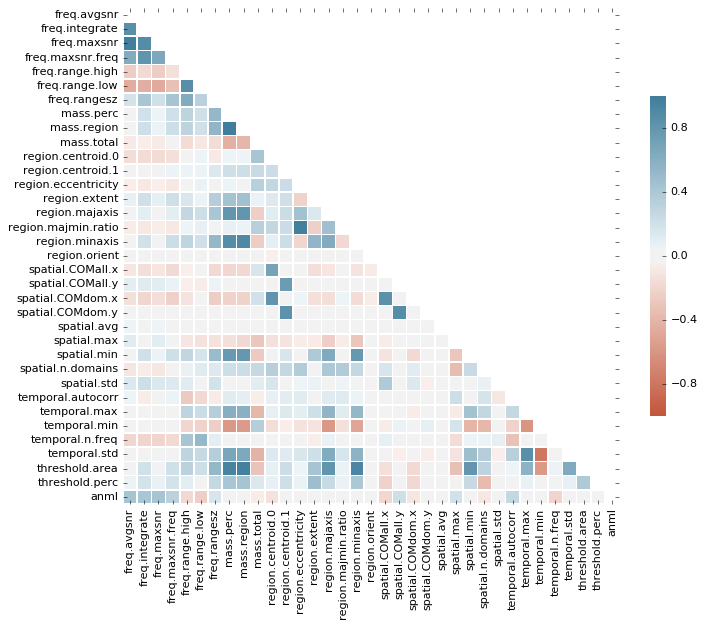

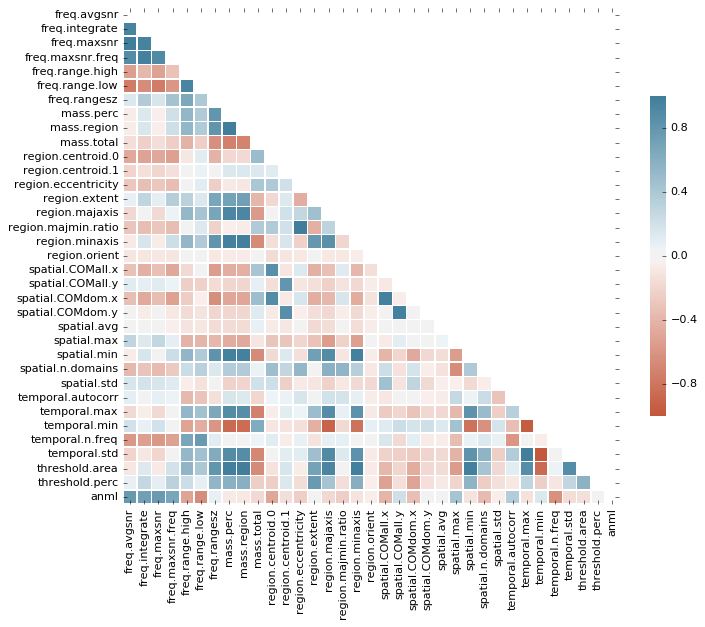

In [17]:
fig = plt.figure( figsize = (10,10), constrained_layout=False)

droplist = ['age', 'artifact', 'length', 'signal']
print(data.columns)
dcorr = data.drop(droplist, axis=1)

dcorr = dcorr.corr('spearman')
mask = np.triu(np.ones_like(dcorr, dtype=np.bool))
# mask = np.zeros_like(dcorr, dtype=np.bool)


pal = sns.diverging_palette(20,230, as_cmap = True, center='light')
sns.heatmap(dcorr, mask = mask, cmap=pal, center = 0, vmin = -1, vmax = 1, square = True, linewidth = .5, cbar_kws={'shrink':0.5})
plt.show()

dcorr = dcorr.corr('pearson')
mask = np.triu(np.ones_like(dcorr, dtype=np.bool))
# mask = np.zeros_like(dcorr, dtype=np.bool)


fig = plt.figure( figsize = (10,10), constrained_layout=False)

pal = sns.diverging_palette(20,230, as_cmap = True, center='light')
sns.heatmap(dcorr, mask = mask, cmap=pal, center = 0, vmin = -1, vmax = 1, square = True, linewidth = .5, cbar_kws={'shrink':0.5})
plt.show()